# Dynamics 365 Business Central Troubleshooting Guide (TSG) - Web services

This notebook contains Kusto queries that can help getting to the root cause of an issue with web services for an environment. 

Each section in the notebook contains links to relevant documentation from the performance tuning guide [aka.ms/bcperformance](aka.ms/bcperformance),   telemetry documentation in [aka.ms/bctelemetry](aka.ms/bctelemetry), as well as Kusto queries that help dive into a specific area.

NB! Some of the signal used in this notebook is only available in newer versions of Business Central, so check the version of your environment if some sections do not return any data. The signal documentation states in which version a given signal was introduced.

**NB!** Telemetry for SOAP endpoints does not emit HTTP status code. So the sections that query for different values of HTTP status will not show results for these requests.

## 1\. Get setup: Load up Python libraries and connect to Application Insights

First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it? Install instructions: https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


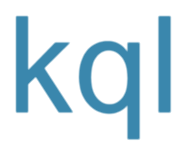

In [1]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [2]:
# Connect to the Application Insights API
#%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'
%kql appinsights://appid='962fbf96-f15e-4d37-8f91-13cae96f4b3e';appkey='8lm6537pckh323nkcp3kjksvxm2cdzt5qt85cbpj'



## 2\. Define filters

This workbook is designed for troubleshooting a single environment. Please provide values for aadTenantId and environmentName  (or use a config file).

In [5]:
# Add values for AAD tenant id, environment name, and extension id here (or use a config file)

# It is possible to leave the value for environment name blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:/tmp/notebook.ini"


# Add AAD tenant id and environment name here
aadTenantId = "MyaaDtenantId"
environmentName = ""
#extensionId = "MyExtensionId"
extensionId = ""

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2020-11-20"
endDate = "2020-11-24"




# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         56ae956a-ef95-4bc7-9795-d2bd84b0bc9c
environmentName     
startDate           2021-03-01
endDate             2021-03-10


# Analyze web service usage
Now you can run Kusto queries to look for possible root causes for issues about web services.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

## Incoming Web service requests overview

Performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)

Incoming Web service telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

KQL sample: [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql)

In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
| extend category = tostring( customDimensions.category )
| summarize request_count=count() by category, bin(timestamp, 1d)
| render timechart title= 'Number of incoming web service requests by category'

In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
 extend category = tostring( customDimensions.category )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000 /1000 //the datatype for executionTime is timespan 
| summarize count() by executionTime_sec = bin(executionTimeInSec, 10), category
| extend log_count = log10( count_ )
| order by category, executionTime_sec asc
| render columnchart with  (ycolumns = log_count, ytitle='log(count)', series = category, title= 'Execution time (in seconds) of incoming ws requests by category' ) 

## Incoming Web service throttling

Operational Limits for Business Central Online:

- [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#query-limits](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#query-limits)

Telemetry docs:

- [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

  

Note that SOAP endpoints do not have http status code in telemetry, so they will show with empty values in that dimension.

In [3]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
| extend httpStatusCode = case(
      isempty(customDimensions.httpStatusCode), 'SOAP (no http status available)'
    , tostring( customDimensions.httpStatusCode )
)
| summarize count() by bin(timestamp, 1d), httpStatusCode
| render timechart title= 'Number of incoming web service requests by http status code'

[{'timestamp': datetime.datetime(2021, 3, 3, 0, 0, tzinfo=tzutc()), 'httpStatusCode': '200', 'count_': 2}]

## Incoming Web service requests (400 Bad Request)

The server cannot or will not process the request due to an apparent client error (e.g., malformed request syntax, size too large, invalid request message framing, or deceptive request routing) ( see [https://en.wikipedia.org/wiki/List_of_HTTP_status_codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) )

Telemetry docs:

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

In [ ]:
%%kql
//
// Top 10 endpoint requests with 400 Bad Request
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.httpStatusCode == '400'
| summarize number_of_requests=count() by endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| order by number_of_requests desc
| limit 10

## Incoming Web service requests (Access denied)

The user who made the request doesn't have proper permissions. For more information, see

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/webservices/web-services-authentication](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/webservices/web-services-authentication)
-   [https://docs.microsoft.com/en-us/dynamics365/business-central/ui-define-granular-permissions](https://docs.microsoft.com/en-us/dynamics365/business-central/ui-define-granular-permissions)

Telemetry docs:

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

In [ ]:
%%kql
//
// Top 10 endpoint requests with access denied
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.httpStatusCode == '401'
| limit 10

## Incoming Web service requests (Not found)

The given endpoint was not valid

See

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/webservices/publish-web-service](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/webservices/publish-web-service)

Telemetry docs:

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

In [ ]:
%%kql
//
// Top 10 non-valid endpoints called
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.httpStatusCode == '404'
| summarize number_of_requests=count() by endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| order by number_of_requests desc
| limit 10

## Incoming Web service requests (Request timed out)

The request took longer to complete than the threshold configured for the service

See

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#ODataServices](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#ODataServices)

Telemetry docs:

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

Performance tuning guide (you need to tune these endpoints to make them go faster)

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)

In [ ]:
%%kql
//
// Top 10 endpoints that times out
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.httpStatusCode == '408'
| summarize number_of_requests=count() by endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| order by number_of_requests desc
| limit 10

## Incoming Web service requests (Too Many Requests)

The request exceeded the maximum simultaneous requests allowed on the service.

See

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#ODataServices](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/operational-limits-online#ODataServices)

Telemetry docs:

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

Performance tuning guide (you need to make your web service client back-off and retry)

-   [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)

In [ ]:
%%kql
//
// Top 10 endpoints get throttled
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.httpStatusCode == '426'
| summarize number_of_requests=count() by endpoint = tostring( customDimensions.endpoint ), alObjectName = tostring( customDimensions.alObjectName ), alObjectId = tostring( customDimensions.alObjectId )
| order by number_of_requests desc
| limit 10

## (Outgoing) web service requests overview 

Performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#web-service-client-performance](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)

Outgoing Web service telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-outgoing-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-outgoing-trace) 

KQL sample: [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/OutGoingWebServiceCalls.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/OutGoingWebServiceCalls.kql) 

Explanation of different HTTP status codes: [https://en.wikipedia.org/wiki/List_of_HTTP_status_codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)

In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)    
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0019'
|extend httpStatusCode = tostring( customDimensions.httpReturnCode )
| summarize request_count=count() by httpStatusCode, bin(timestamp, 1d)
| order by httpStatusCode asc
| render timechart title= 'Number of outgoing web service requests by HTTP status code'

In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)        
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0019'
| extend httpMethod = tostring( toupper( customDimensions.httpMethod ) )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000 /1000 //the datatype for executionTime is timespan 
| where executionTimeInSec <= 10
| summarize count() by executionTime_sec = bin(executionTimeInSec, 1), httpMethod
| extend log_count = log10( count_ )
| order by httpMethod, executionTime_sec asc
| render columnchart with  (ycolumns = log_count, ytitle='log10(count)', series = httpMethod, title= 'Execution time (seconds) of "normal" outgoing ws requests by method' ) 


In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)        
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0019'
| extend httpMethod = tostring( toupper( customDimensions.httpMethod ) )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000 /1000 //the datatype for executionTime is timespan 
| where executionTimeInSec > 10
| summarize count() by executionTime_sec = bin(executionTimeInSec, 10), httpMethod
| extend log_count = log10( count_ )
| order by httpMethod, executionTime_sec asc
| render columnchart with  (ycolumns = log_count, ytitle='log10(count)', series = httpMethod, title= 'Execution time (seconds) of slow outgoing ws requests by method' ) 


In [ ]:
%%kql
//
// Top 20 most expensive outgoing calls
//
// Includes descriptive statistics avg, min, max, and 95 percentile for execution time and number of calls
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)    
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0019'
| extend httpMethod = tostring( toupper( customDimensions.httpMethod ) )
       , executionTimeInMS = toreal(totimespan(customDimensions.serverExecutionTime))/10000 //the datatype for executionTime is timespan 
       , alObjectId = tostring( customDimensions.alObjectId )
       , alObjectName = tostring( customDimensions.alObjectName )
       , alObjectType = tostring( customDimensions.alObjectType )
, endpoint = tostring( customDimensions.endpoint )
, extensionId = tostring( customDimensions.extensionId )
, extensionName = tostring( customDimensions.extensionName )
, extensionVersion = tostring( customDimensions.extensionVersion )
| summarize avg(executionTimeInMS), min(executionTimeInMS), max(executionTimeInMS),percentile(executionTimeInMS,95), count() by 
  httpMethod
, alObjectId, alObjectName, alObjectType
, extensionId, extensionName, extensionVersion
, endpoint
| order by avg_executionTimeInMS desc
| project avg_timeInSec=round(avg_executionTimeInMS/1000,2)
, min_timeInSec=round(min_executionTimeInMS/1000,2)
, max_timeInSec=round(max_executionTimeInMS/1000,2)
, perc_95InSec=round(percentile_executionTimeInMS_95/1000,2), count_, alObjectId, alObjectName, alObjectType, extensionId, extensionName, extensionVersion, httpMethod, endpoint
| limit 20